### Prediction of New York City Taxi Fares
In the first sections of this project we will transform the dataset in order to create new useful datetime and distance features, with this new features we will try to predict the fare amount of the taxi rides along with another features. In the final sections of this project I will try to predict the fare class using embeddings and PyTorch embedding layers for the zipcodes.

Description of the dataset

Features:
 
- pickup_datetime - timestamp value indicating when the taxi ride started.
- pickup_longitude - float for longitude coordinate of where the taxi ride started.
- pickup_latitude - float for latitude coordinate of where the taxi ride started.
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
- passenger_count - integer indicating the number of passengers in the taxi ride.

Target
- fare_amount: float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

### Get the traveled distance with the coordinates

A Regression approach that correlates the traveled distance with the fare amount per ride needs a traveled distance calculation with the coordinates provided. For this reason a new feature could be calculated with the Haversine formula that calculates the distance on a sphere between two sets of GPS coordinates. With this, we reduce the complexity of the travel with a straight line. 

The distance formula works out to

$${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import time

### Setting device, reproducibility and Early Stopping 

In [4]:
has_mps = torch.backends.mps.is_built()
# device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using device: {device}")
torch.manual_seed(42)

# Defining an early stopping class for PyTorch
import copy
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.patience_counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model.state_dict())
    elif self.best_loss - val_loss >= self.min_delta:
      self.best_model = copy.deepcopy(model.state_dict())
      self.best_loss = val_loss
      self.status = f"Improvement!!!, actual counter {self.patience_counter}"
      self.patience_counter = 0
    else:
      self.patience_counter += 1
      self.status = f"NO improvement in the last {self.patience_counter} epochs"
      if self.patience_counter >= self.patience:
        self.status = f"Early stopping triggered after {self.patience_counter} epochs."
        if self.restore_best_weights:
          model.load_state_dict(self.best_model)
        return True
    return False

Using device: cpu


### Import dataset and drop NA values

In [5]:
# read the MPG dataset
df = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### Estimating the traveled distance per ride with the Haversine Formula

In [6]:
# function to calculate the distance of the travel
def haversine_distance(df, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[lon2] - df[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

# append a 'dist_km' new feature in the dataframe
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

### Descriptive analytics
Check and remove outliers

In [7]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

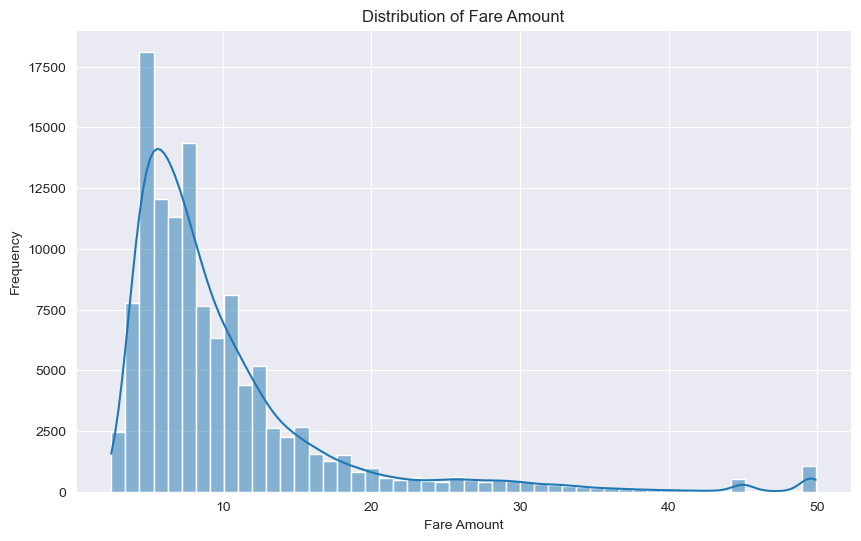

In [8]:
# Plotting the distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

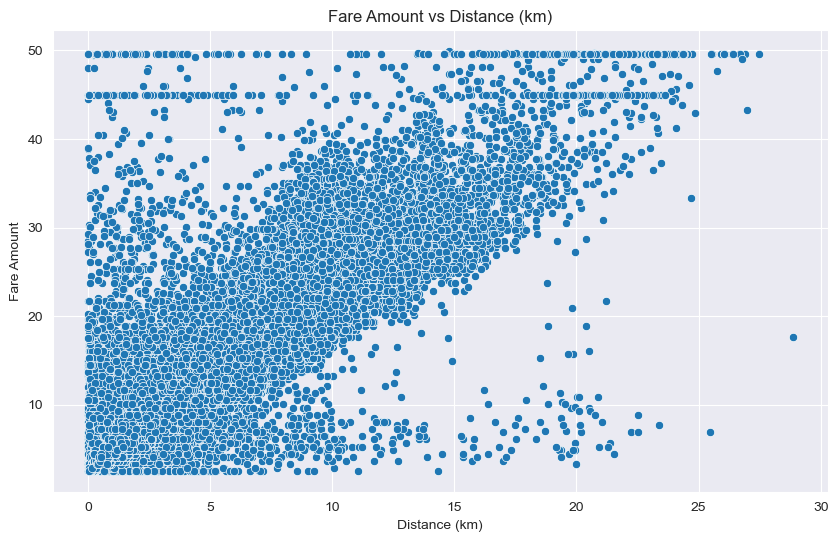

In [9]:
# Plotting the scatter plot of fare_amount vs dist_km
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dist_km'], y=df['fare_amount'])
plt.title('Fare Amount vs Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.show()

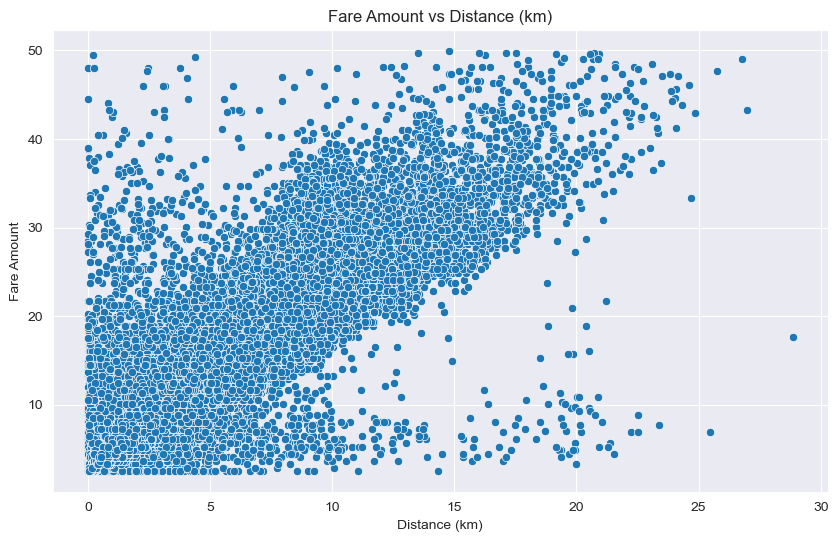

In [10]:
df = df[(df['fare_amount'] != 49.57) & (df['fare_amount'] != 45.00)]
# Plotting the scatter plot of fare_amount vs dist_km
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['dist_km'], y=df['fare_amount'])
plt.title('Fare Amount vs Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.show()

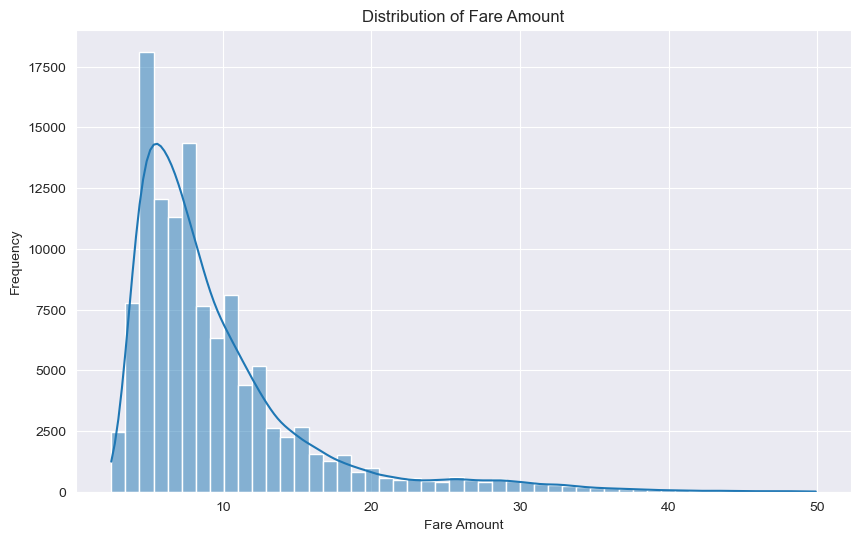

In [12]:
# Plotting the distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

In [13]:
df['fare_amount'].describe()

count    118481.000000
mean          9.552663
std           6.174697
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

### Time datatypes transformations and charts
To work with the special pandas dtype timestamps the to_datetime method can be used.

In [14]:
# actual dtypes
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

Correcting pickup_datetime due to daylight savings time (April) There is a 4 hour difference between the value in the dataframe and the real NYC time. Eastern Day Time.

In [15]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

Extract new features from the time series

In [16]:
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12, 'am', 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

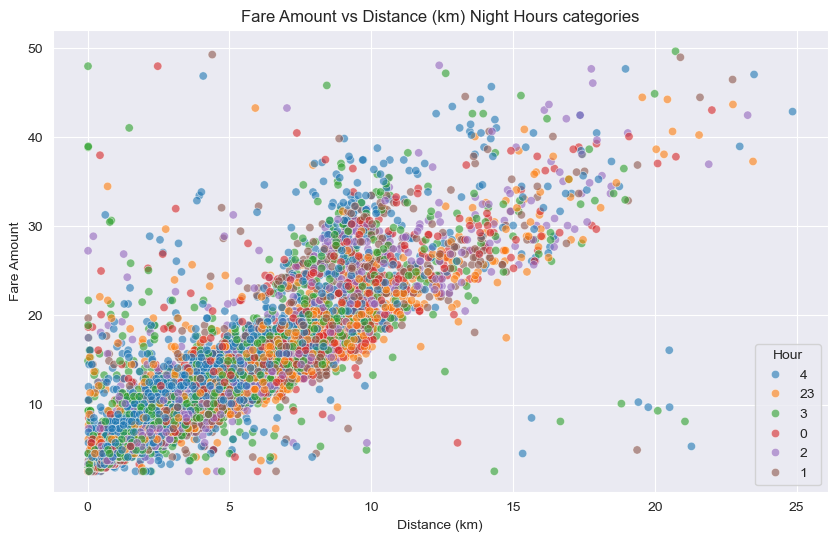

In [17]:
# Filter the dataframe to include only rows of Night Hours
df_filtered = df[df['Hour'].isin([23,0,1,2,3,4])]

# Plotting the scatter plot of fare_amount vs dist_km colored by Night Hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_filtered['dist_km'], y=df_filtered['fare_amount'], hue=df_filtered['Hour'].astype(str), alpha=0.6)
plt.title('Fare Amount vs Distance (km) Night Hours categories')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount')
plt.legend(title='Hour')
plt.show()

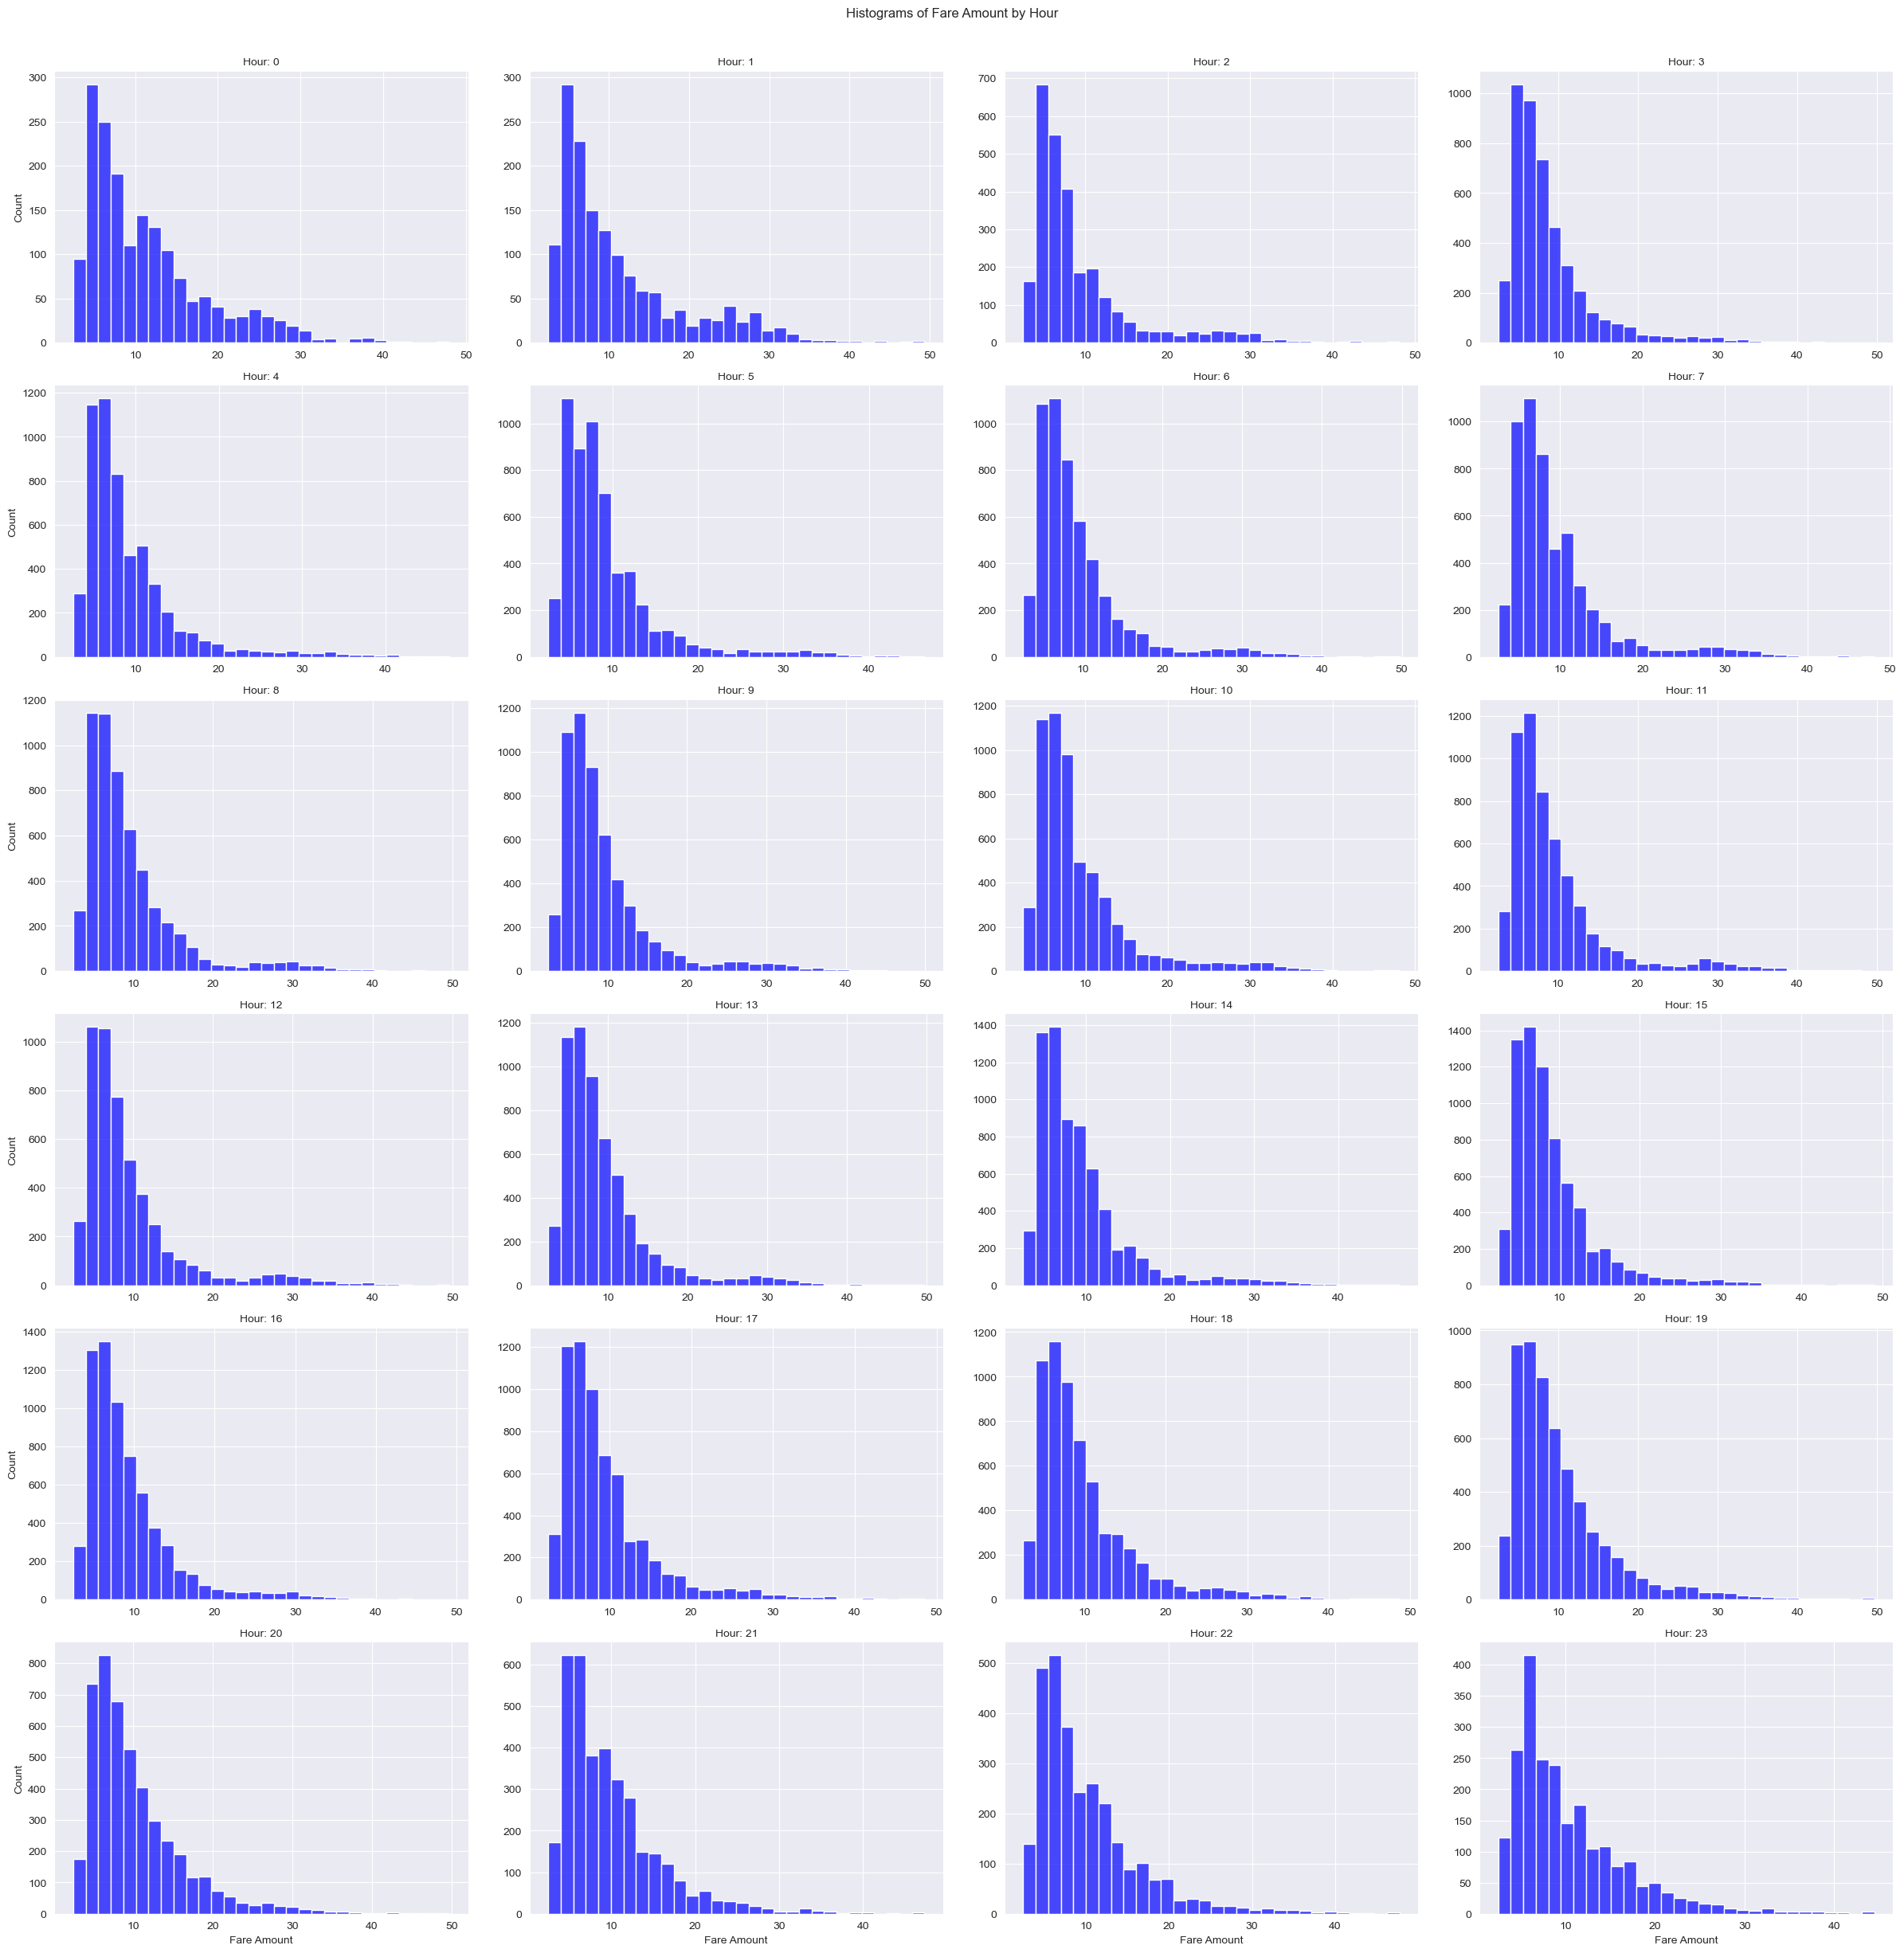

In [18]:
# Create a FacetGrid to plot histograms for each 'Hour' category
g = sns.FacetGrid(df, col='Hour', col_wrap=4, height=4, aspect=1.5, sharex=False, sharey=False)
g.map(sns.histplot, 'fare_amount', kde=False, bins=30, color='blue', alpha=0.7)

# Add titles and labels
g.set_titles(col_template='Hour: {col_name}')
g.set_axis_labels('Fare Amount', 'Count')
g.fig.suptitle('Histograms of Fare Amount by Hour', y=1.02)

plt.show()

### Managing categorical and continuous values in Pandas
Defining arbitrary continuous categories, arbitrary continuous columns and the target feature

In [19]:
# set a list of categorical fields
cat_cols = ['Hour', 'AMorPM', 'Weekday']

# set a list of continuous fields
cont_cols = ['passenger_count', 'dist_km']

# this column contains the labels (Y)
y_col = ['fare_amount']

# transform to pandas categorical variables
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

### Numpy arrays for training datasets

In [20]:
# create categorical codes matrix with list comprehension
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

# create continuous matrix with list comprehension
conts = np.stack([df[col].values for col in cont_cols], axis=1)

# create labels numpy (y)
y = df[y_col].values.reshape(-1, 1)

### Creating lists of Categorical sizes for PyTorch Embedding Layers

In [21]:
# categorical sizes list
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

# embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]

### Tabular model definition

In [22]:
class TabularModel(nn.Module):
    def __init__(self, emb_sizes_s, n_cont, out_sizes, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes_s])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes_s])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
            
        layer_list.append(nn.Linear(layers[-1], out_sizes))
        """In Python, the asterisk (*) operator is used for unpacking a list or a tuple. """
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Function to split not in 4 (trains x 2, tests x 2) but in 6 (trains x 3, tests x 3) the selected dataset for automated learning using array slices

In [31]:
def get_train_test(categoricals, continuous, y_train, test_size=0.2):
    # Ensure the input arrays have the same number of rows
    assert categoricals.shape[0] == continuous.shape[0] == y_train.shape[0], "Input arrays must have the same number of rows"

    # Combine the data into a single array for splitting
    combined = np.hstack((categoricals, continuous, y_train))

    # Split the combined data into train and test sets
    train_data, test_data = train_test_split(combined, test_size=test_size, random_state=42)

    # Determine the number of categorical and continuous columns
    n_cat_cols = categoricals.shape[1]
    n_cont_cols = continuous.shape[1]

    # Separate the train and test data back into categorical, continuous, and target tensors

    # selects all rows and the first n_cat_cols columns (categorical features).
    cat_train = torch.tensor(train_data[:, :n_cat_cols], dtype=torch.int64).to(device)

    # selects all rows and the columns from n_cat_cols to n_cat_cols + n_cont_cols (continuous features).
    con_train = torch.tensor(train_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)

    # selects all rows and the last column (target labels).
    y_train = torch.tensor(train_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    cat_test = torch.tensor(test_data[:, :n_cat_cols], dtype=torch.int64).to(device)
    con_test = torch.tensor(test_data[:, n_cat_cols:n_cat_cols + n_cont_cols], dtype=torch.float32).to(device)
    y_test = torch.tensor(test_data[:, -1], dtype=torch.float32).unsqueeze(1).to(device)

    return cat_train, con_train, y_train, cat_test, con_test, y_test

cat_train, con_train, y_train, cat_test, con_test, y_test = get_train_test(cats, conts, y)

### Defining training instances
There are two possible Loss Functions that can be used for regression tasks: MSELoss and SmoothL1Loss. The Adam optimizer is recommended for the regression task.

In [32]:
# model instance (output_size = 1 for regression task)
model = TabularModel(emb_sizes, conts.shape[1], 1, [400, 200, 100, 50], p=0.3).to(device)

# criteria
criterion_1 = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# TensorDatasets
train_dataset = TensorDataset(cat_train, con_train, y_train)
test_dataset = TensorDataset(cat_test, con_test, y_test)

batch_size = 128

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# early stop 
early_stopping = EarlyStopping(patience=20)

# results
results = []

### MSELoss Training loop

In [33]:
# Training loop
train_losses = []
val_losses = []

epochs = 100
start_time = time.time()
for epoch in range(epochs):
    model.train()
    epoch_losses = []

    for cat_batch, con_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(cat_batch, con_batch).flatten()
        loss = torch.sqrt(criterion_1(y_pred, y_batch.flatten()))  # Use y_batch.flatten() here
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(epoch_losses))

    # Validation
    model.eval()
    with torch.no_grad():
        epoch_val_loss = []
        for cat_batch, con_batch, y_batch in test_loader:
            y_val = model(cat_batch, con_batch).flatten()
            val_loss = torch.sqrt(criterion_1(y_val, y_batch.flatten()))  # Use y_batch.flatten() here
            epoch_val_loss.append(val_loss.item())

        val_losses.append(np.mean(epoch_val_loss))

    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}')
    
    results.append({
        "Optimizer": "MSELoss", 
        "Epoch": epoch + 1,
        "Train Loss": train_losses[-1],
        "Validation Loss": val_losses[-1],
    })
    
    # Check early stopping
    if early_stopping(model, val_losses[-1]):  # Pass the latest validation loss to early stopping
        print(early_stopping.status)
        break

print(f'Training completed in {time.time() - start_time:.2f} seconds')

Epoch 1/100, Train Loss: 5.4598, Validation Loss: 2.8544, Early S: 
Epoch 6/100, Train Loss: 3.1212, Validation Loss: 2.8254, Early S: Improvement!!!, actual counter 1
Epoch 11/100, Train Loss: 3.0550, Validation Loss: 2.7399, Early S: NO improvement in the last 2 epochs
Epoch 16/100, Train Loss: 3.0452, Validation Loss: 2.7489, Early S: NO improvement in the last 1 epochs
Epoch 21/100, Train Loss: 3.0156, Validation Loss: 2.7318, Early S: NO improvement in the last 6 epochs
Epoch 26/100, Train Loss: 3.0079, Validation Loss: 2.7542, Early S: Improvement!!!, actual counter 10
Epoch 31/100, Train Loss: 2.9976, Validation Loss: 2.7786, Early S: NO improvement in the last 5 epochs
Epoch 36/100, Train Loss: 2.9677, Validation Loss: 2.7247, Early S: NO improvement in the last 2 epochs
Epoch 41/100, Train Loss: 2.9628, Validation Loss: 2.7428, Early S: NO improvement in the last 7 epochs
Epoch 46/100, Train Loss: 2.9468, Validation Loss: 2.7272, Early S: NO improvement in the last 12 epochs
E

In [34]:
# Function to reset weights and biases
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
       m.reset_parameters()

# Apply the reset function to each layer
model.apply(reset_weights)

# model instance (output_size = 1 for regression task)
model = TabularModel(emb_sizes, conts.shape[1], 1, [400, 200, 100, 50], p=0.3).to(device)

# criteria
criterion_2 = nn.SmoothL1Loss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# TensorDatasets
train_dataset = TensorDataset(cat_train, con_train, y_train)
test_dataset = TensorDataset(cat_test, con_test, y_test)

batch_size = 128

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# early stop 
early_stopping = EarlyStopping(patience=20)

### SmoothL1Loss Training loop

In [35]:
# Training loop
train_losses = []
val_losses = []

epochs = 100
start_time = time.time()
for epoch in range(epochs):
    model.train()
    epoch_losses = []

    for cat_batch, con_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(cat_batch, con_batch).flatten()
        loss = torch.sqrt(criterion_2(y_pred, y_batch.flatten()))  # Use y_batch.flatten() here
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    train_losses.append(np.mean(epoch_losses))

    # Validation
    model.eval()
    with torch.no_grad():
        epoch_val_loss = []
        for cat_batch, con_batch, y_batch in test_loader:
            y_val = model(cat_batch, con_batch).flatten()
            val_loss = torch.sqrt(criterion_2(y_val, y_batch.flatten()))  # Use y_batch.flatten() here
            epoch_val_loss.append(val_loss.item())

        val_losses.append(np.mean(epoch_val_loss))

    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Early S: {early_stopping.status}')
        
    results.append({
        "Optimizer": "SmoothL1Loss", 
        "Epoch": epoch + 1,
        "Train Loss": train_losses[-1],
        "Validation Loss": val_losses[-1],
    })

    # Check early stopping
    if early_stopping(model, val_losses[-1]):  # Pass the latest validation loss to early stopping
        print(early_stopping.status)
        break

print(f'Training completed in {time.time() - start_time:.2f} seconds')

Epoch 1/100, Train Loss: 1.7861, Validation Loss: 1.1084, Early S: 
Epoch 6/100, Train Loss: 1.1962, Validation Loss: 1.0851, Early S: Improvement!!!, actual counter 0
Epoch 11/100, Train Loss: 1.1800, Validation Loss: 1.0854, Early S: NO improvement in the last 1 epochs
Epoch 16/100, Train Loss: 1.1721, Validation Loss: 1.0799, Early S: Improvement!!!, actual counter 2
Epoch 21/100, Train Loss: 1.1650, Validation Loss: 1.0752, Early S: Improvement!!!, actual counter 4
Epoch 26/100, Train Loss: 1.1598, Validation Loss: 1.0698, Early S: NO improvement in the last 5 epochs
Epoch 31/100, Train Loss: 1.1523, Validation Loss: 1.0707, Early S: NO improvement in the last 2 epochs
Epoch 36/100, Train Loss: 1.1515, Validation Loss: 1.0884, Early S: NO improvement in the last 7 epochs
Epoch 41/100, Train Loss: 1.1464, Validation Loss: 1.0699, Early S: NO improvement in the last 12 epochs
Epoch 46/100, Train Loss: 1.1444, Validation Loss: 1.0739, Early S: NO improvement in the last 17 epochs
Earl

In [36]:
results_df = pd.DataFrame(results)

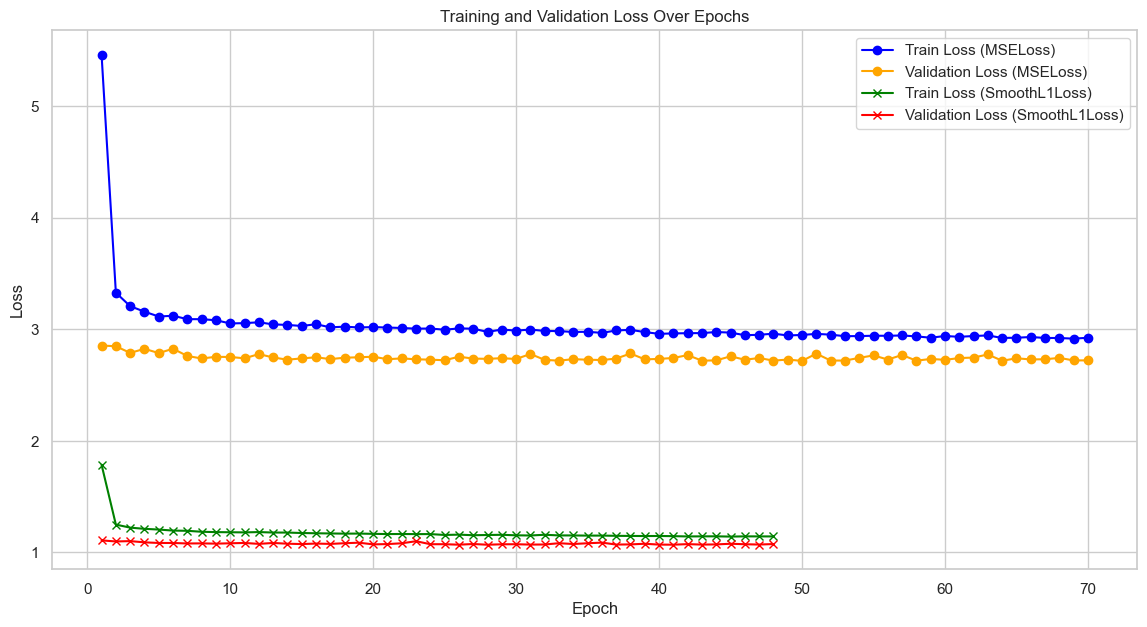

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Filter results for MSELoss
mse_results = results_df[results_df["Optimizer"] == "MSELoss"]

# Plot Train and Validation Loss
plt.plot(mse_results['Epoch'], mse_results['Train Loss'], label='Train Loss (MSELoss)', color='blue', marker='o')
plt.plot(mse_results['Epoch'], mse_results['Validation Loss'], label='Validation Loss (MSELoss)', color='orange', marker='o')

# Filter results for SmoothL1Loss
smooth_results = results_df[results_df["Optimizer"] == "SmoothL1Loss"]

# Plot Train and Validation Loss
plt.plot(smooth_results['Epoch'], smooth_results['Train Loss'], label='Train Loss (SmoothL1Loss)', color='green', marker='x')
plt.plot(smooth_results['Epoch'], smooth_results['Validation Loss'], label='Validation Loss (SmoothL1Loss)', color='red', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()